In [2]:
# cancer tumor data TCGA-PANCAN-HiSeq-801x20531
# data website
# https://archive-beta.ics.uci.edu/dataset/401/gene+expression+cancer+rna+seq
# load the data from csv files
import pandas as pd
import numpy as np

# load the data from csv files
data = pd.read_csv('data.csv').drop('Unnamed: 0', axis=1)
# labels are different types of tumors
labels = pd.read_csv('labels.csv').drop('Unnamed: 0', axis=1)


In [3]:
print(np.unique(labels['Class']))
print(data.shape)

['BRCA' 'COAD' 'KIRC' 'LUAD' 'PRAD']
(801, 20531)


In [4]:
data.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


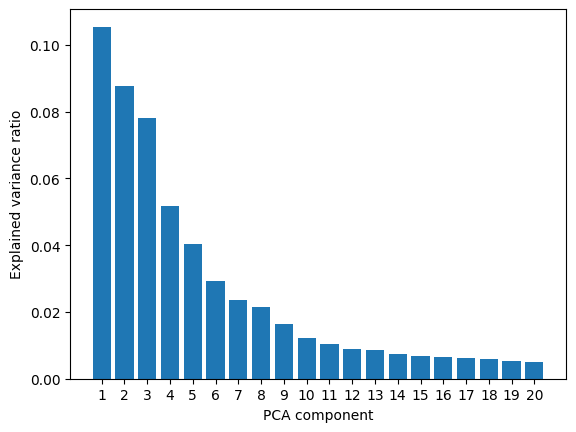

In [20]:
# PCA analysis for 10 components

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# standardize the data
data_scaled = StandardScaler().fit_transform(data)

# PCA analysis
pca = PCA(n_components=20)
pca.fit(data_scaled)
data_pca = pca.transform(data_scaled)

# create a bar plot of the explained variance for each component
plt.bar(range(1,21), pca.explained_variance_ratio_)
plt.xlabel('PCA component')
plt.ylabel('Explained variance ratio')
# set the x ticks with the names of the components
plt.xticks(range(1,21))
plt.show()


